# Results Analysis

## Imports

In [1]:
!pip install -q pandas seaborn

You should consider upgrading via the '/home/gabriel/UnB/TCC/Hardness-Sampling/notebooks/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install colorcet

You should consider upgrading via the '/home/gabriel/UnB/TCC/Hardness-Sampling/notebooks/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from IPython.display import display, clear_output

## Definitions

### Constants

In [4]:
RESULT_DIR  = '../results/'

#### Strategies

In [5]:
CLASSIC = { 'margin_sampling', 'training_utility_sampling', 'density_weighted_sampling', 'expected_error_reduction', 'random_sampling'}
NEIGHBORHOOD = {'borderline_points_sampling', 'k_disagreeing_neighbors_sampling', 'local_set_cardinality_sampling',
                'ls_radius_sampling', 'intra_extra_ratio_sampling', 'harmfulness_sampling', 'usefulness_sampling'}
LIKELIHOOD = {'class_likelihood_sampling', 'class_likeliood_diff_sampling'}
FEATURE_BASED = {'f1_sampling', 'f2_sampling', 'f3_sampling', 'f4_sampling'}
TREE_BASED = {'disjunct_class_percentage_sampling', 'disjunct_size_sampling', 'tree_depth_pruned_sampling',
              'tree_depth_unpruned_sampling'}
CLASS_BALANCE = {'class_balance_sampling', 'minority_value_sampling'}

In [6]:
ABREV_DICT = {
    'random_sampling': 'Rnd',
    'margin_sampling': 'MS',
    'training_utility_sampling': 'TU',
    'density_weighted_sampling': 'ID',
    'expected_error_reduction': 'EER$_{ent}$',
    'borderline_points_sampling': 'N1I',
    'k_disagreeing_neighbors_sampling': 'kDN',
    'local_set_cardinality_sampling': 'LSCI',
    'ls_radius_sampling': 'LSR',
    'intra_extra_ratio_sampling': r'N2I',
    'harmfulness_sampling': 'H',
    'usefulness_sampling': 'U',
    'class_likelihood_sampling': 'CL',
    'class_likeliood_diff_sampling': 'CLD',
    'f1_sampling': 'F1I',
    'f2_sampling': 'F2I',
    'f3_sampling': 'F3I',
    'f4_sampling': 'F4I',
    'disjunct_class_percentage_sampling': 'DCP',
    'disjunct_size_sampling': 'DS',
    'tree_depth_pruned_sampling': 'TD$_P$',
    'tree_depth_unpruned_sampling': 'TD$_U$',
    'class_balance_sampling': 'CB',
    'minority_value_sampling': 'MV'
}

In [7]:
ABREV_MODEL = {
   'GaussianNB': 'NB',
   'SVC': 'SVM',
   'DecisionTree': 'CART',
   '5NN': '5NN',
}

### Helper Functions

In [8]:
def get_hm_type(x: str):
    if x in CLASSIC: return 'Classic'
    if x in NEIGHBORHOOD: return 'Neighbor-based'
    if x in LIKELIHOOD: return 'Likelihood-based'
    if x in FEATURE_BASED: return 'Feature-based'
    if x in TREE_BASED: return 'Tree-based'
    if x in CLASS_BALANCE: return 'Class-Balance'
        
        

In [9]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [10]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC:
        return '-.'
    elif method in NEIGHBORHOOD:
        return '^-'
    elif method in LIKELIHOOD:
        return 's-'
    elif method in FEATURE_BASED:
        return '*-'
    elif method in TREE_BASED:
        return 'h-'
    else:
        return 'd-'

In [11]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [12]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [13]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [14]:
def plot_ranking_curves(data: pd.DataFrame, model:str, group_strategies=False):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5, min_periods=1).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 linewidth=0.7,
                 markevery=(0.3, 0.2))


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(bbox_to_anchor=(1.01,1), ncol=1, shadow=True)

    # Grid
    plt.grid()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')

# plot_ranking_curves(df, 'SVC')

In [15]:
def plot_ranks_with_bands(df, ax, model=None, group_bands=False, log=False, ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    
    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands

    rank = dict()
    if model is None:
        for model_name, df in ranked_df_smoothed.groupby('model'):
            color = ax._get_lines.get_next_color()
            ax.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                            alpha=0.1,
                            color=color)



        # Plot Best Strategy for each model
            best_strategy = auc_series.loc[model_name].idxmax()
            best_score = auc_series.loc[model_name].max()
            strategy_name = ABREV_DICT[best_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            rank[label] = best_score
            
            ax.plot(ranked_df_smoothed.loc[model_name, best_strategy],
                    get_style(best_strategy),
                    label=label,
                    markevery=(0.5,0.6),
                    markersize=4,
                    linewidth=0.8, color=color)
            
            worst_strategy = auc_series.loc[model_name].idxmin()
            worst_score = auc_series.loc[model_name].min()
            strategy_name = ABREV_DICT[worst_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            rank[label] = worst_score
            
            ax.plot(ranked_df_smoothed.loc[model_name, worst_strategy],
                     get_style(worst_strategy),
                     label=label,
                     markevery=(0.5, 0.6),
                    markersize=4,
                     linewidth=0.8, color=color)
            
    if model and not group_bands:
        
        color_list = sns.color_palette(cc.glasbey_dark ,n_colors=len(ranked_df_smoothed.loc[model]))
    
        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            ax.plot(ranked_df_smoothed.loc[model, strategy],
                    get_style(strategy),
                    label=ABREV_DICT[strategy],
                    color=color_list[i],
                    markevery=(0.2, 0.33),
                    markersize=4,
                    linewidth=0.8)
            
    ax.set_xticks(range(0, 110, 10))
    ax.grid()
    ax.set_xlabel('Queries')
    ax.set_ylabel('Mean Ranking Position')

    if log == True:
        ax.set_xscale('log')
        
    return rank
        


In [16]:
def get_ranks_df(df, model=None ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')
    
    auc_series.name = 'auc_score'

    model_auc_df = auc_series.loc[model].sort_values(ascending=False).reset_index()
        
    model_auc_df['group'] = model_auc_df['strategy'].apply(get_hm_type)
    
    return model_auc_df[["strategy", "group", "auc_score"]]


## Data Gathering

In [17]:
RESULT_FILES = !find $RESULT_DIR -type f 

In [18]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [19]:
index_columns = ['dataset', 'model', 'strategy']

In [20]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

## Data Analysis

In [45]:
df.loc[(slice(None), 'SVC', 'expected_error_reduction'), :]

,,,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
dataset,model,strategy,,,,,,,,,,,,,,,,,,,,,
spambase,SVC,expected_error_reduction,-0.000435,0.067857,0.103360,0.163007,0.171228,0.178071,0.179482,0.175770,0.177983,0.149975,...,0.243966,0.213444,0.213403,0.212986,0.212578,0.211393,0.211096,0.211096,0.209044,0.212180
lymphography,SVC,expected_error_reduction,0.097352,0.006582,0.098199,0.071080,0.146080,0.081545,0.081545,0.071080,0.064621,0.241415,...,0.594124,0.594124,0.594124,0.581384,0.581384,0.594639,0.580890,0.580890,0.581467,0.581467
molecular-splice-junction,SVC,expected_error_reduction,0.050187,0.052442,0.017318,0.019802,0.010771,0.011080,0.071483,0.057855,0.056206,0.081352,...,0.395582,0.401313,0.401349,0.406024,0.408579,0.419876,0.412782,0.428465,0.438031,0.438092
thyroid-sick-euthyroid,SVC,expected_error_reduction,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ozone-eighthr,SVC,expected_error_reduction,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wdbc,SVC,expected_error_reduction,0.291986,0.234548,0.183562,0.291986,0.291986,0.469420,0.463413,0.526722,0.629138,0.647616,...,0.760770,0.760770,0.764174,0.764174,0.764174,0.764174,0.764174,0.764174,0.764990,0.764990
mammographic-mass,SVC,expected_error_reduction,0.117140,0.018457,0.141779,0.050489,0.101805,0.000000,0.149855,0.110605,0.144899,0.146987,...,0.255131,0.265928,0.265382,0.264056,0.267628,0.253673,0.259951,0.262000,0.267694,0.267313
statlog-australian-credit,SVC,expected_error_reduction,-0.032976,-0.050855,-0.021645,0.047905,0.031912,0.045324,0.040942,0.033420,0.035188,0.033760,...,0.194168,0.194700,0.198269,0.198269,0.200907,0.203779,0.203779,0.200489,0.200489,0.200489


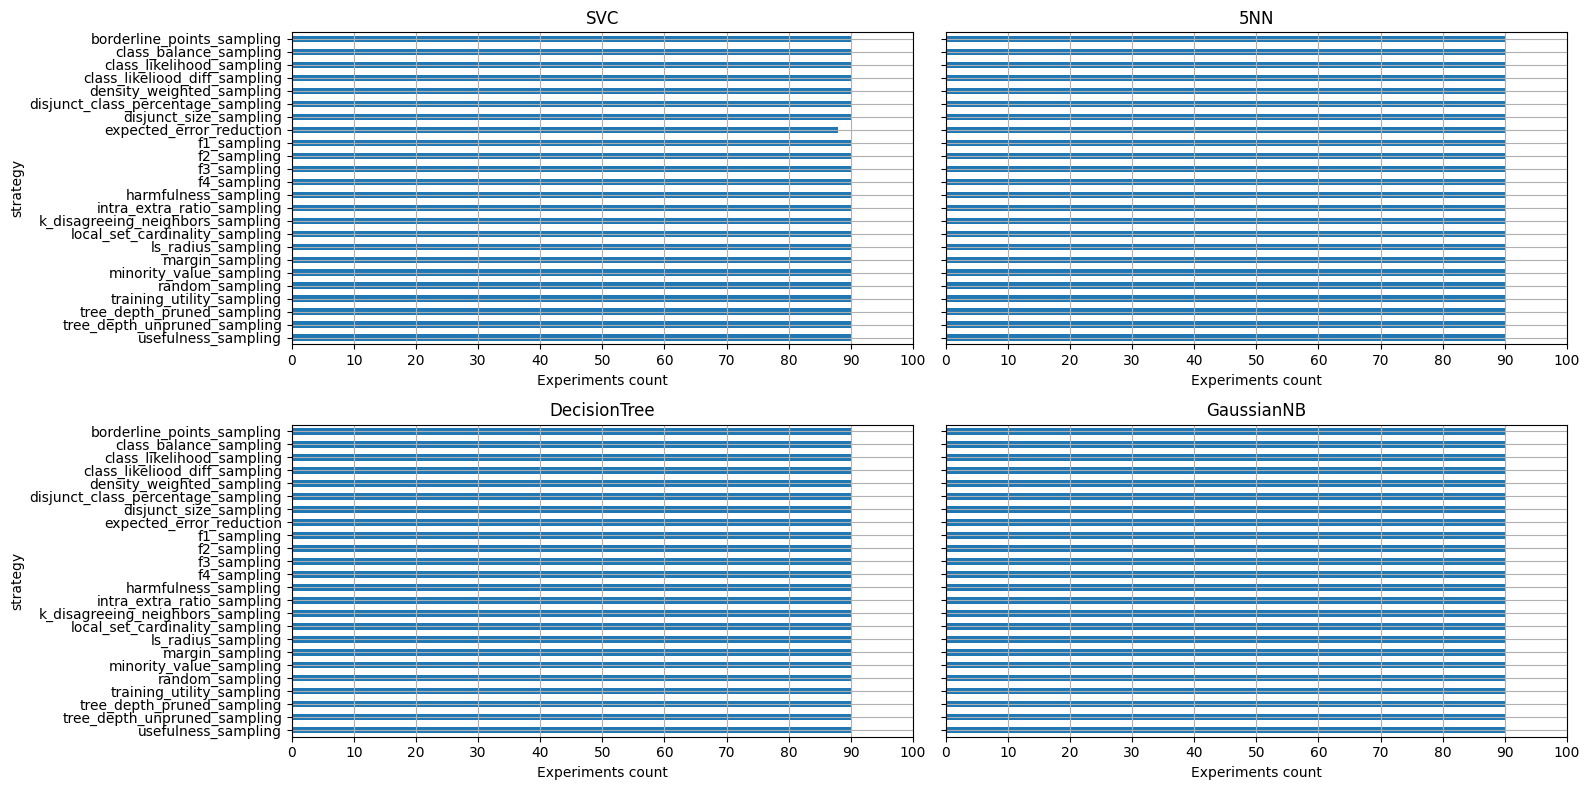

In [21]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='DecisionTree')
show_counts(df, ax=axs[1, 1], model='GaussianNB')


fig.tight_layout()

## Ranking Curves

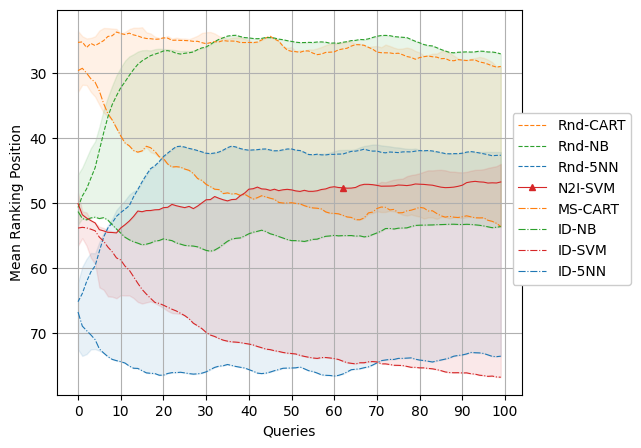

In [22]:
_, ax = plt.subplots(1, 1, figsize=(6,5))
rank = plot_ranks_with_bands(df, ax=ax)
plt.gca().invert_yaxis()

sorted_labels = [e[0] for e in sorted(rank.items(), key=lambda x: x[1], reverse=True)]

handles, labels = plt.gca().get_legend_handles_labels()
label_to_handle = {l: h for l, h in zip(labels, handles)}
    
plt.legend([label_to_handle[label] for label in sorted_labels],
           sorted_labels,
           loc='upper right', bbox_to_anchor=(1.25,.75), ncol=1, framealpha=1)

plt.savefig('Images/general_ranking_curves.png', dpi=400, bbox_inches='tight')

In [23]:
def plot_model_ranking_curves(model, *ylim):
    fig, ax = plt.subplots(1,1, figsize=(6, 5))
    plot_ranks_with_bands(df,ax=ax, model=model, log=False)
    plt.gca().invert_yaxis()
    
    ranks_df  = get_ranks_df(df, model=model)
    ranks_df.strategy = ranks_df.strategy.apply(lambda x: ABREV_DICT[x])
    sorted_labels = ranks_df.strategy
    
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}
    
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    plt.ylim(ylim)
    plt.savefig(f'Images/{ABREV_MODEL[model]}_ranking_curves.png', dpi=400, bbox_inches='tight')
    plt.show()

## 5NN

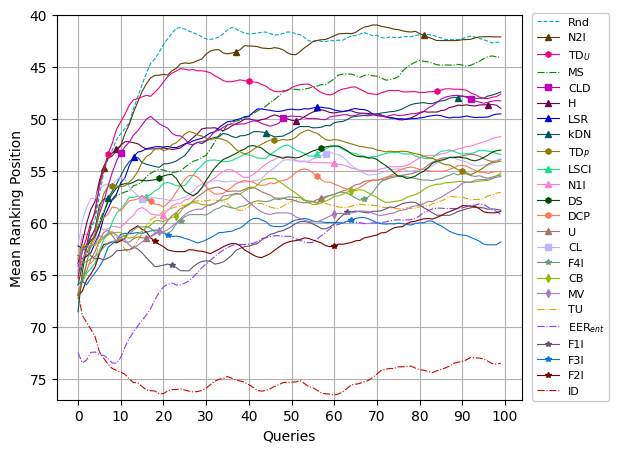

In [24]:
plot_model_ranking_curves('5NN', 77, 40)

## CART

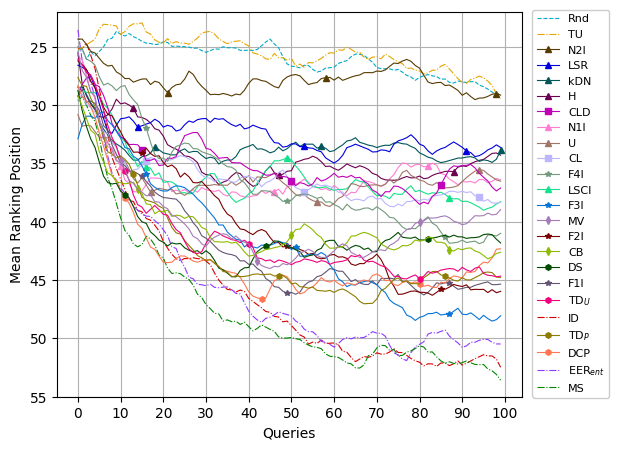

In [25]:
plot_model_ranking_curves('DecisionTree', 55, 22)

## NB

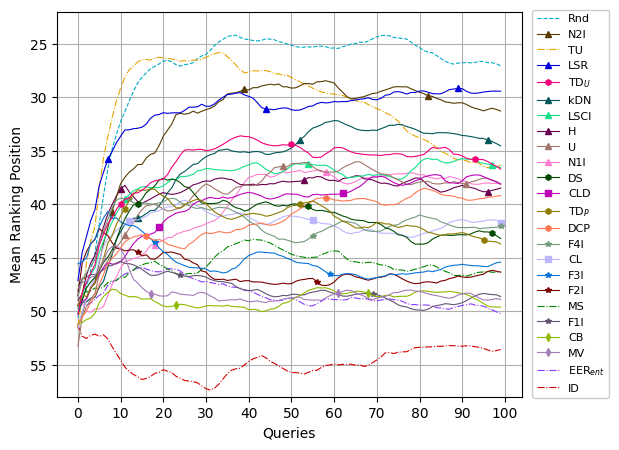

In [26]:
plot_model_ranking_curves('GaussianNB', 58, 22)

## SVM

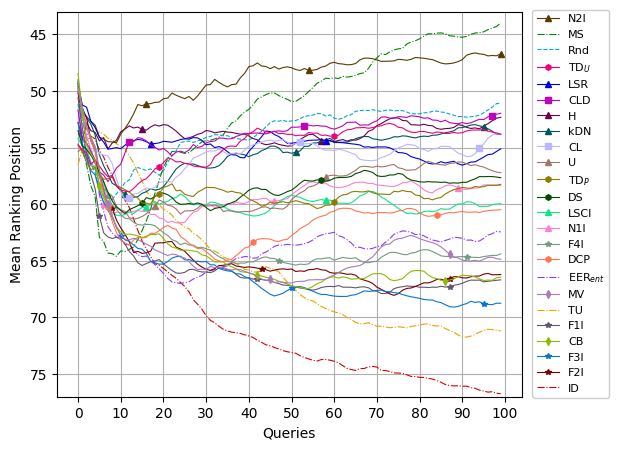

In [27]:
plot_model_ranking_curves('SVC', 77, 43)

## Comparação de Categorias

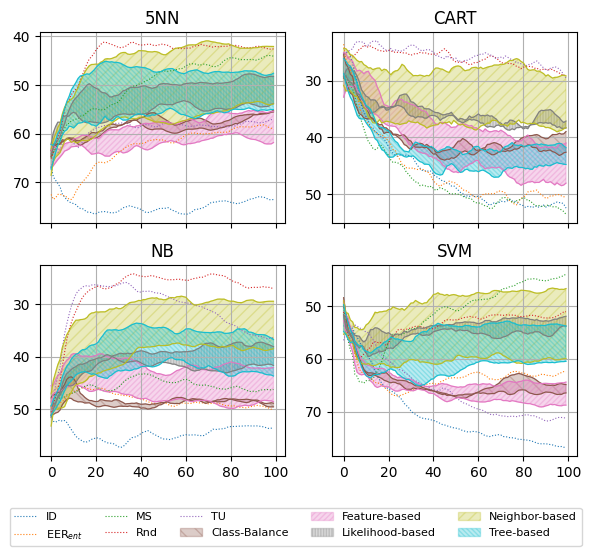

In [28]:
def get_hm_hatch(x: str):
    if x == 'Neighbor-based': return '///'
    if x == 'Likelihood-based':  return '||||||'
    if x == 'Feature-based': return '//////'
    if x == 'Tree-based' : return '\\\\\\\\\\\\\\'
    if x == 'Class-Balance': return '\\\\'
        
def plot_ranks_with_groups(df, ax, model):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    
    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    ranked_df_smoothed['type'] = ranked_df_smoothed.index.map(lambda x: get_hm_type(x[1]))
    ranked_df_smoothed.set_index('type', append=True, inplace=True)


    classic_df = ranked_df_smoothed.query('model == @model and type == "Classic"')
    
    for (_ , s , _), row in classic_df.iterrows():
        ax.plot(row, label=ABREV_DICT[s], linewidth=0.8, linestyle=':')

    for (m, t), foo, in ranked_df_smoothed.groupby(['model', 'type']):
        if m != model or t == 'Classic':
            continue
        
        color = ax._get_lines.get_next_color()
        
        ax.fill_between(np.arange(foo.shape[1]), foo.max(), foo.min(),
                        alpha=0.3, color=color, label=t, hatch=get_hm_hatch(t))
        ax.plot(foo.max(), markevery=(0.3, 0.2), color=color, marker=None, linewidth=0.8)
        ax.plot(foo.min(), markevery=(0.3, 0.2), color=color, marker=None, linewidth=0.8)
            
    ax.set_xticks(range(0, 110, 20))
    ax.grid()
    # ax.set_xlabel('Queries')
    # ax.set_ylabel('Mean Ranking Position')


fig, axs = plt.subplots(2,2, figsize=(6, 5), sharex=True)
for model , ax in zip(["5NN", "DecisionTree", "GaussianNB", "SVC"], axs.flatten()):
    plot_ranks_with_groups(df, ax, model)        
    ax.invert_yaxis()
    ax.set_title(ABREV_MODEL[model])
    
plt.tight_layout()    

plt.legend(loc="lower center",bbox_to_anchor=(-0.15,-0.5),ncol=5, prop={'size': 8})
plt.savefig('Images/group_bands.png', dpi=400, bbox_inches='tight')

## Tabelas

In [29]:
ranked_df = df.groupby('dataset').rank(ascending=False)

mean_rank = ranked_df.groupby(['model', 'strategy']).apply(lambda x: x.stack().mean())
std_rank = ranked_df.groupby(['model', 'strategy']).apply(lambda x: x.stack().std())
rank_table =  pd.concat([mean_rank, std_rank], axis=1)
rank_table.columns = ['mean_rank', 'std_rank']
rank_table.sort_values(by='mean_rank', inplace=True)
rank_table.reset_index(inplace=True)

rank_table['group'] = rank_table.strategy.apply(lambda x: get_hm_type(x) if x not in CLASSIC else None)
rank_table.model =rank_table.model.apply(lambda x: ABREV_MODEL[x])
rank_table.strategy = rank_table.strategy.apply(lambda x: ABREV_DICT[x])
rank_table['mean_std'] = rank_table.apply(lambda row: f"${row['mean_rank']:.2f}\pm{row['std_rank']:.2f}$", axis=1)
rank_table['learner_method'] = rank_table.apply(lambda row: f"{row['strategy']}-{row['model']}", axis=1)


# marca melhores e piores posições
for _, records in rank_table.groupby('model'):
    
    best, worst = records.mean_rank.idxmin(), records.mean_rank.idxmax()
    
    rank_table.at[best, 'learner_method'] = f"\\textbf{{{rank_table.at[best, 'learner_method']}}}*"
    rank_table.at[worst, 'learner_method'] = f"\\textbf{{{rank_table.at[worst, 'learner_method']}}}"
    
# marca baseline
rnd_index = rank_table.strategy == 'Rnd'
rank_table.loc[rnd_index, 'learner_method'] = rank_table.loc[rnd_index].learner_method.apply(lambda x: f"\\underline{{{x}}}")
rank_table

,model,strategy,mean_rank,std_rank,group,mean_std,learner_method
0,CART,TU,25.653222,23.376603,None,$25.65\pm23.38$,\textbf{TU-CART}*
1,CART,Rnd,26.175556,21.546466,None,$26.18\pm21.55$,\underline{Rnd-CART}
2,NB,Rnd,27.093500,24.718453,None,$27.09\pm24.72$,\underline{\textbf{Rnd-NB}*}
3,CART,N2I,27.880611,24.383755,Neighbor-based,$27.88\pm24.38$,N2I-CART
4,NB,TU,30.788222,26.759473,None,$30.79\pm26.76$,TU-NB
...,...,...,...,...,...,...,...
91,SVM,TU,65.936500,21.283864,None,$65.94\pm21.28$,TU-SVM
92,SVM,F1I,66.101222,24.732593,Feature-based,$66.10\pm24.73$,F1I-SVM
93,SVM,F3I,66.404833,22.752820,Feature-based,$66.40\pm22.75$,F3I-SVM
94,SVM,ID,70.787333,21.142277,None,$70.79\pm21.14$,\textbf{ID-SVM}


### Tabela LaTeX

In [30]:
# seleciona colunas
rank_table_latex = rank_table[['mean_std', 'learner_method', 'group']]

# Salva arquivo
header = ['Avg. Rank Pos.', 'Method-Learner', 'Group']
rank_table_latex[:48].to_latex(index=False, buf=open('Tables/table_rank.tex', 'w'), header=header, na_rep='-')
rank_table_latex[48:].to_latex(index=False, buf=open('Tables/table_rank.tex', 'a'), header=header, na_rep='-')

rank_table_latex

,mean_std,learner_method,group
0,$25.65\pm23.38$,\textbf{TU-CART}*,None
1,$26.18\pm21.55$,\underline{Rnd-CART},None
2,$27.09\pm24.72$,\underline{\textbf{Rnd-NB}*},None
3,$27.88\pm24.38$,N2I-CART,Neighbor-based
4,$30.79\pm26.76$,TU-NB,None
...,...,...,...
91,$65.94\pm21.28$,TU-SVM,None
92,$66.10\pm24.73$,F1I-SVM,Feature-based
93,$66.40\pm22.75$,F3I-SVM,Feature-based
94,$70.79\pm21.14$,\textbf{ID-SVM},None


### Top 5 por Learner

In [31]:
rank_table.groupby('model').apply(lambda x: x.head(5))

model strategy  mean_rank   std_rank             group  \
model                                                             
5NN   37   5NN      Rnd  43.801222  25.942689              None   
      38   5NN      N2I  44.434889  24.468755    Neighbor-based   
      44   5NN   TD$_U$  47.813611  22.869068        Tree-based   
      51   5NN       MS  49.476889  24.539333              None   
      52   5NN      CLD  50.649556  24.459677  Likelihood-based   
CART  0   CART       TU  25.653222  23.376603              None   
      1   CART      Rnd  26.175556  21.546466              None   
      3   CART      N2I  27.880611  24.383755    Neighbor-based   
      7   CART      LSR  32.657111  25.232633    Neighbor-based   
      8   CART      kDN  33.769389  24.107217    Neighbor-based   
NB    2     NB      Rnd  27.093500  24.718453              None   
      4     NB       TU  30.788222  26.759473              None   
      5     NB      LSR  31.104889  23.173205    Neighbor-based   
      6     NB      N2I  31.805389  25.084876    Neighbor-based   
      11    NB      kDN  35.945944  24.375124    Neighbor-based   
SVM   49   SVM      N2I  48.852556  29.752792    Neighbor-based   
      55   SVM       MS  51.382611  28.943590              None   
      58   SVM        H  53.611167  28.971425    Neighbor-based   
      59   SVM      Rnd  53.624056  29.474513              None   
      60   SVM      CLD  53.699333  28.242495  Likelihood-based   

                 mean_std                 learner_method  
model                                                     
5NN   37  $43.80\pm25.94$  \underline{\textbf{Rnd-5NN}*}  
      38  $44.43\pm24.47$                        N2I-5NN  
      44  $47.81\pm22.87$                     TD$_U$-5NN  
      51  $49.48\pm24.54$                         MS-5NN  
      52  $50.65\pm24.46$                        CLD-5NN  
CART  0   $25.65\pm23.38$              \textbf{TU-CART}*  
      1   $26.18\pm21.55$           \underline{Rnd-CART}  
      3   $27.88\pm24.38$                       N2I-CART  
      7   $32.66\pm25.23$                       LSR-CART  
      8   $33.77\pm24.11$                       kDN-CART  
NB    2   $27.09\pm24.72$   \underline{\textbf{Rnd-NB}*}  
      4   $30.79\pm26.76$                          TU-NB  
      5   $31.10\pm23.17$                         LSR-NB  
      6   $31.81\pm25.08$                         N2I-NB  
      11  $35.95\pm24.38$                         kDN-NB  
SVM   49  $48.85\pm29.75$              \textbf{N2I-SVM}*  
      55  $51.38\pm28.94$                         MS-SVM  
      58  $53.61\pm28.97$                          H-SVM  
      59  $53.62\pm29.47$            \underline{Rnd-SVM}  
      60  $53.70\pm28.24$                        CLD-SVM

### Bottom 5 per learner

In [32]:
rank_table.groupby('model').apply(pd.DataFrame.tail)

model     strategy  mean_rank   std_rank          group  \
model                                                              
5NN   81   5NN          F3I  60.835556  23.265043  Feature-based   
      82   5NN          F1I  60.969056  23.841113  Feature-based   
      83   5NN          F2I  61.340500  23.919212  Feature-based   
      85   5NN  EER$_{ent}$  62.822333  22.873585           None   
      95   5NN           ID  74.771889  21.444288           None   
CART  35  CART       TD$_P$  42.821778  24.230183     Tree-based   
      36  CART          DCP  43.272444  24.730958     Tree-based   
      41  CART  EER$_{ent}$  46.222444  24.934503           None   
      43  CART           ID  46.575778  26.883538           None   
      46  CART           MS  47.948667  25.216378           None   
NB    45    NB          F1I  47.917667  26.866965  Feature-based   
      47    NB           MV  48.239722  24.718312  Class-Balance   
      48    NB  EER$_{ent}$  48.409500  28.590623           None   
      50    NB           CB  48.914500  27.811119  Class-Balance   
      61    NB           ID  54.697833  29.104901           None   
SVM   90   SVM          F2I  65.106833  23.507663  Feature-based   
      91   SVM           TU  65.936500  21.283864           None   
      92   SVM          F1I  66.101222  24.732593  Feature-based   
      93   SVM          F3I  66.404833  22.752820  Feature-based   
      94   SVM           ID  70.787333  21.142277           None   

                 mean_std    learner_method  
model                                        
5NN   81  $60.84\pm23.27$           F3I-5NN  
      82  $60.97\pm23.84$           F1I-5NN  
      83  $61.34\pm23.92$           F2I-5NN  
      85  $62.82\pm22.87$   EER$_{ent}$-5NN  
      95  $74.77\pm21.44$   \textbf{ID-5NN}  
CART  35  $42.82\pm24.23$       TD$_P$-CART  
      36  $43.27\pm24.73$          DCP-CART  
      41  $46.22\pm24.93$  EER$_{ent}$-CART  
      43  $46.58\pm26.88$           ID-CART  
      46  $47.95\pm25.22$  \textbf{MS-CART}  
NB    45  $47.92\pm26.87$            F1I-NB  
      47  $48.24\pm24.72$             MV-NB  
      48  $48.41\pm28.59$    EER$_{ent}$-NB  
      50  $48.91\pm27.81$             CB-NB  
      61  $54.70\pm29.10$    \textbf{ID-NB}  
SVM   90  $65.11\pm23.51$           F2I-SVM  
      91  $65.94\pm21.28$            TU-SVM  
      92  $66.10\pm24.73$           F1I-SVM  
      93  $66.40\pm22.75$           F3I-SVM  
      94  $70.79\pm21.14$   \textbf{ID-SVM}